In [35]:
import os
import torch
import argparse
from tqdm import tqdm
from utils import get_exp_config, print_arguments
from utils.trainer import ETSequencedMiniBatchTrainer, ETSGCNTrainer
from EigenTrajectory import EigenTrajectory
from baseline.sgcn.model import TrajectoryModel
from baseline.sgcn.bridge import model_forward_pre_hook, model_forward, model_forward_post_hook

In [18]:
config_path = "./config/eigentrajectory-sgcn-hotel.json"
hyper_params = get_exp_config(config_path)
print("===== Configs =====")
print_arguments(hyper_params)

===== Configs =====
dataset_dir: ./datasets/ | checkpoint_dir: ./checkpoints/ | dataset: hotel | traj_dim: 2 | 
obs_len: 8 | obs_step: 10 | pred_len: 12 | pred_step: 10 | skip: 1 | k: 6 | static_dist: 0.353 | 
num_samples: 20 | obs_svd: True | pred_svd: True | baseline: sgcn | batch_size: 128 | 
num_epochs: 256 | lr: 0.001 | weight_decay: 0.0001 | clip_grad: 10 | lr_schd: True | 
lr_schd_step: 64 | lr_schd_gamma: 0.5


In [ ]:
args = argparse.Namespace(
    tag="EigenTrajectory-SGCN",
    test=True
)
hook_func = argparse.Namespace(
    model_forward_pre_hook=model_forward_pre_hook,
    model_forward=model_forward,
    model_forward_post_hook=model_forward_post_hook
)
trainer = ETSGCNTrainer(
    base_model=TrajectoryModel,
    model=EigenTrajectory,
    hook_func=hook_func,
    args=args,
    hyper_params=hyper_params
)

Trainer initiating...
Checkpoint dir: ./checkpoints//EigenTrajectory-SGCN/hotel/


Test HOTEL scene:   0%|          | 0/301 [00:00<?, ?it/s]

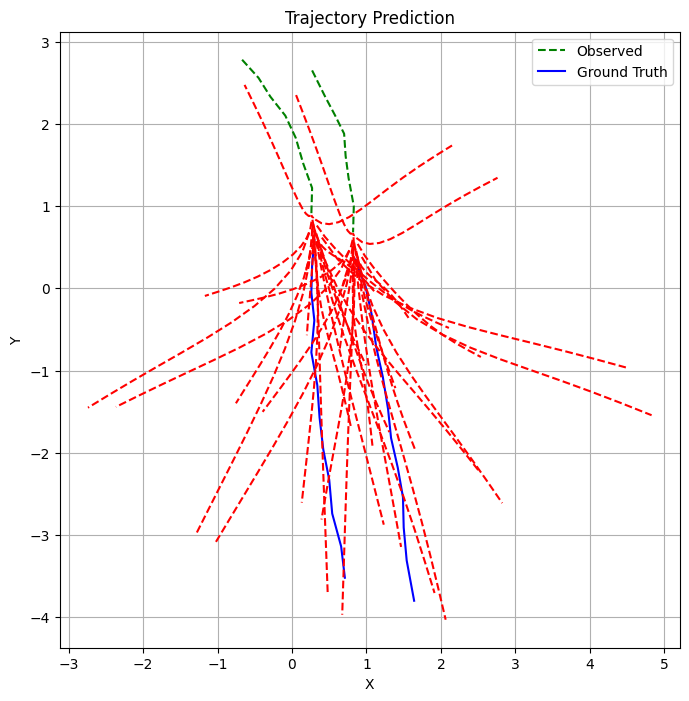

Test HOTEL scene:   2%|▏         | 7/301 [00:00<00:10, 28.25it/s]


In [74]:
import matplotlib.pyplot as plt
trainer.load_model('model_best.pth')
trainer.model.eval()
trainer.reset_metric()
pred_color = 'r'  # Красный для предсказанных
gt_color = 'b'    # Синий для ground truth

for batch in tqdm(trainer.loader_test, desc=f"Test {trainer.hyper_params.dataset.upper()} scene"):
            obs_traj, pred_traj = [tensor.cuda(non_blocking=True) for tensor in batch[:2]]
            # Trajectory noise perturbation
            # obs_traj = obs_traj + torch.randn_like(obs_traj) * 0.10
            if obs_traj[1,1,1] == obs_traj[1,2,1]:
                   continue
            output = trainer.model(obs_traj)
            pred_traj_recon = output["recon_traj"]  # Предсказанные траектории, форма [num_samples, n_ped, t_pred, dim]
            
            # Преобразование на CPU для визуализации
            obs_traj = obs_traj.detach().cpu().numpy()
            pred_traj = pred_traj.detach().cpu().numpy()
            pred_traj_recon = pred_traj_recon.detach().cpu().numpy()  # Используем первое предсказание из num_samples

            # Визуализация
            plt.figure(figsize=(8, 8))
            
            # Наблюдаемые траектории
            for i in range(obs_traj.shape[0]):
                plt.plot(obs_traj[i, :, 0], obs_traj[i, :, 1], 'g--', label="Observed" if i == 0 else "")  # Зелёный (наблюдаемая)

            # Истинные траектории
            for i in range(pred_traj.shape[0]):
                plt.plot(pred_traj[i, :, 0], pred_traj[i, :, 1], f'{gt_color}-', label="Ground Truth" if i == 0 else "")

            for pedestr in range(pred_traj_recon.shape[1]):
                for sample in range(pred_traj_recon.shape[0]):
                    plt.plot(pred_traj_recon[sample, pedestr, :, 0], pred_traj_recon[sample, pedestr, :, 1], f'{pred_color}--', label="Predicted" if i == 0 else "")
                    

            # Предсказанные траектории
            #for i in range(pred_traj_recon.shape[0]):
            #    plt.plot(pred_traj_recon[i, :, 0], pred_traj_recon[i, :, 1], f'{pred_color}--', label="Predicted" if i == 0 else "")

            # Оформление графика
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.title("Trajectory Prediction")
            plt.grid()
            plt.show()

            # Нарисуем только первый батч для наглядности
            break

In [43]:
print(output['recon_traj'].shape)

torch.Size([20, 2, 12, 2])


In [ ]:
results = trainer.test()
print("Результаты тестирования:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Test HOTEL scene:   0%|          | 0/301 [00:00<?, ?it/s]